# MA3831 A3 WebCrawler and NLP System

In [45]:
# Import Libraries
import requests
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
import pickle

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import PorterStemmer

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import xgboost as xgb
from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, \
    precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Chose the https://www.imdb.com/chart/top/?ref_=nv_mv_250&sort=user_rating%2Cdesc website to look through, instead of the default "ranking" they use. Unsure as to what that ranking is based off so using user rating for each movie in descending order for the top 250. 

# Task 2: Web scrapping

In [3]:
# Functions for
def get_html(url):
    """Return html from given url."""
    page = requests.get(url)
    return page


def clean_html(page):
    """Clean html from website."""
    soup = BeautifulSoup(page.text, 'lxml')
    return soup


def print_html(soup):
    """Print html from website."""
    print(soup.prettify())


def extract_names_with_keyword(strings_list, keyword):
    return [' '.join(string.split()[1:]) for string in strings_list if keyword in string]

In [11]:
# Retrieve html from website
url = 'https://editorial.rottentomatoes.com/guide/best-movies-of-all-time/'
webpage = get_html(url)

In [12]:
webpage = clean_html(webpage)

In [13]:
# Print html from webpage
print_html(webpage)

<!DOCTYPE html>
<html class="hitim" lang="en-US">
 <head prefix="og: http://ogp.me/ns# flixstertomatoes: http://ogp.me/ns/apps/flixstertomatoes#">
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <!-- OneTrust Cookies Consent Notice start for rottentomatoes.com -->
  <script charset="UTF-8" crossorigin="anonymous" data-domain-script="7e979733-6841-4fce-9182-515fac69187f" integrity="sha384-TKdmlzVmoD70HzftTw4WtOzIBL5mNx8mXSRzEvwrWjpIJ7FZ/EuX758yMDWXtRUN" src="https://cdn.cookielaw.org/consent/7e979733-6841-4fce-9182-515fac69187f/otSDKStub.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   function OptanonWrapper() { }
  </script>
  <!-- OneTrust Cookies Consent Notice end for rottentomatoes.com -->
  <!-- OneTrust IAB US Privacy (USP) -->
  <script ccpa-opt-out-geo="US" ccpa-opt-out-ids="USP" ccpa-opt-out-lspa="false" charset="UTF-8" src="https://cdn.cookielaw.org/opt-out/otCCPAiab.js" type="text/javascript">
  </script>
  <!-- OneTrust 

In [14]:
# retrieve movie titles from html
scraped_movies = webpage.find_all('a', class_='title')
print(scraped_movies)
len(scraped_movies)  # Expected 300 movies

[<a class="title" href="https://www.rottentomatoes.com/m/la_confidential">L.A. Confidential</a>, <a class="title" href="https://www.rottentomatoes.com/m/the_godfather">The Godfather</a>, <a class="title" href="https://www.rottentomatoes.com/m/1003707-casablanca">Casablanca</a>, <a class="title" href="https://www.rottentomatoes.com/m/seven_samurai_1956">Seven Samurai</a>, <a class="title" href="https://www.rottentomatoes.com/m/parasite_2019">Parasite</a>, <a class="title" href="https://www.rottentomatoes.com/m/schindlers_list">Schindler's List</a>, <a class="title" href="https://www.rottentomatoes.com/m/top_gun_maverick">Top Gun: Maverick</a>, <a class="title" href="https://www.rottentomatoes.com/m/toy_story_2">Toy Story 2</a>, <a class="title" href="https://www.rottentomatoes.com/m/chinatown">Chinatown</a>, <a class="title" href="https://www.rottentomatoes.com/m/on_the_waterfront">On the Waterfront</a>, <a class="title" href="https://www.rottentomatoes.com/m/the_battle_of_algiers">The 

300

In [15]:
# Get movie titles
titles = []

for title in scraped_movies:
    titles.append(title.get_text().strip())
print(titles)
len(titles)

['L.A. Confidential', 'The Godfather', 'Casablanca', 'Seven Samurai', 'Parasite', "Schindler's List", 'Top Gun: Maverick', 'Toy Story 2', 'Chinatown', 'On the Waterfront', 'The Battle of Algiers', 'Toy Story', 'Rear Window', 'Modern Times', 'How to Train Your Dragon', 'All About Eve', 'Spirited Away', 'Up', 'The Third Man', 'Spotlight', 'Spider-Man: Into the Spider-Verse', 'The Philadelphia Story', 'Finding Nemo', "Singin' in the Rain", '12 Angry Men', 'Toy Story 3', 'Sunset Boulevard', 'Coco', 'The Godfather, Part II', 'Three Colors: Red', 'Selma', 'Zootopia', 'Citizen Kane', 'Annie Hall', 'Cool Hand Luke', 'The Holdovers', 'Inside Out', 'Dr. Strangelove Or: How I Learned to Stop Worrying and Love the Bomb', 'Let the Right One In', 'The Lord of the Rings: The Two Towers', 'Knives Out', 'M', 'Toy Story 4', 'The Wrestler', 'Goodfellas', 'The Wizard of Oz', 'Double Indemnity', 'Psycho', 'Paddington 2', 'Before Sunrise', 'The Dark Knight', 'The Maltese Falcon', 'It Happened One Night', 'T

300

In [16]:
# Get URLS for movies
urls = []

for link in scraped_movies:
    urls.append(link.get('href'))
print(urls)
len(urls)

['https://www.rottentomatoes.com/m/la_confidential', 'https://www.rottentomatoes.com/m/the_godfather', 'https://www.rottentomatoes.com/m/1003707-casablanca', 'https://www.rottentomatoes.com/m/seven_samurai_1956', 'https://www.rottentomatoes.com/m/parasite_2019', 'https://www.rottentomatoes.com/m/schindlers_list', 'https://www.rottentomatoes.com/m/top_gun_maverick', 'https://www.rottentomatoes.com/m/toy_story_2', 'https://www.rottentomatoes.com/m/chinatown', 'https://www.rottentomatoes.com/m/on_the_waterfront', 'https://www.rottentomatoes.com/m/the_battle_of_algiers', 'https://www.rottentomatoes.com/m/toy_story', 'https://www.rottentomatoes.com/m/1017289-rear_window', 'https://www.rottentomatoes.com/m/modern_times', 'https://www.rottentomatoes.com/m/how_to_train_your_dragon', 'https://www.rottentomatoes.com/m/1000626-all_about_eve', 'https://www.rottentomatoes.com/m/spirited_away', 'https://www.rottentomatoes.com/m/up', 'https://www.rottentomatoes.com/m/the_third_man', 'https://www.rott

300

Have scrapped through the Rotten Tomatoes website and have gotten movie titles and the urls for each movie. Next need to scrap through each of the urls for each movie and get movie details like, released date, genre, rating, synopsis, director, 
Didn't take reviews as it doesnt relate to the movie genre


In [17]:
# Scrap through urls
movie_url = 'https://www.rottentomatoes.com/m/la_confidential'

movie = get_html(movie_url)
movie = clean_html(movie)
print(movie)

<!DOCTYPE html>
<html dir="ltr" lang="en" prefix="fb: http://www.facebook.com/2008/fbml og: http://opengraphprotocol.org/schema/" xmlns="http://www.w3.org/1999/xhtml">
<head prefix="og: http://ogp.me/ns# flixstertomatoes: http://ogp.me/ns/apps/flixstertomatoes#">
<script charset="UTF-8" crossorigin="anonymous" data-domain-script="7e979733-6841-4fce-9182-515fac69187f" integrity="sha384-TKdmlzVmoD70HzftTw4WtOzIBL5mNx8mXSRzEvwrWjpIJ7FZ/EuX758yMDWXtRUN" src="https://cdn.cookielaw.org/consent/7e979733-6841-4fce-9182-515fac69187f/otSDKStub.js" type="text/javascript">
</script>
<script type="text/javascript">
                function OptanonWrapper() { }
            </script>
<script ccpa-opt-out-geo="US" ccpa-opt-out-ids="USP" ccpa-opt-out-lspa="false" charset="UTF-8" src="https://cdn.cookielaw.org/opt-out/otCCPAiab.js" type="text/javascript">
</script>
<script src="/assets/pizza-pie/javascripts/bundles/roma/rt-common.js?single"></script>
<meta content="text/html; charset=utf-8" http-equiv="

In [95]:
info = movie.find_all('div', class_='category-wrap')
print(info)

# director = str(info.get('Director')).strip()
# print(director)

[<div class="category-wrap">
<dt class="key">
<rt-text class="key" size="0.875">Director</rt-text>
</dt>
<dd>
<rt-link href="/celebrity/krzysztof_kieslowski">Krzysztof Kieslowski</rt-link>
</dd>
</div>, <div class="category-wrap">
<dt class="key">
<rt-text class="key" size="0.875">Producer</rt-text>
</dt>
<dd>
<rt-link href="/celebrity/marin_karmitz">Marin Karmitz</rt-link>
</dd>
</div>, <div class="category-wrap">
<dt class="key">
<rt-text class="key" size="0.875">Screenwriter</rt-text>
</dt>
<dd>
<rt-link href="/celebrity/krzysztof_kieslowski">Krzysztof Kieslowski</rt-link><rt-text class="delimiter">, </rt-text>
<rt-link href="/celebrity/krzysztof_piesiewicz">Krzysztof Piesiewicz</rt-link>
</dd>
</div>, <div class="category-wrap">
<dt class="key">
<rt-text class="key" size="0.875">Production Co</rt-text>
</dt>
<dd>
<rt-text>RTS - Radio Télévision Suisse</rt-text><rt-text class="delimiter">, </rt-text>
<rt-text>CAB Productions</rt-text><rt-text class="delimiter">, </rt-text>
<rt-text>

In [79]:
description = movie.find('div', class_='synopsis-wrap').text.strip()
name = ' '.join(description.split()[1:])

print(name)

Synopsis
Three policemen, each with his own motives and obsessions, tackle the corruption surrounding an unsolved murder at a downtown Los Angeles coffee shop in the early 1950s. Detective Lieutenant Exley (Guy Pearce), the son of a murdered detective, is out to avenge his father's killing. The ex-partner of Officer White (Russell Crowe), implicated in a scandal rooted out by Exley, was one of the victims. Sergeant Vincennes (Kevin Spacey) feeds classified information to a tabloid magnate (Danny DeVito).


In [128]:
movies = []

# for url in urls:
for url in urls:
    infos = []
    print(f"Getting {url}")
    director, rating, genre, synopsis = "", "", "", ""
    movie = get_html(url)
    movie = clean_html(movie)
    # get all data from the category-wrap class
    movie_details = movie.find_all('div', class_='category-wrap')
    # print(info)
    print("Appending to list")
    for row in movie_details:
        infos.append(row.get_text().strip().replace('\n', ' '))
    print("Getting movie details")
    try:
        director = extract_names_with_keyword(strings_list=infos, keyword="Director")
        print(f"The director is: {director}")
    except:
        pass
    try:
        rating = extract_names_with_keyword(strings_list=infos, keyword="Rating")
        print(f"The rating is: {rating}")
    except:
        pass
    try:
        genre = extract_names_with_keyword(strings_list=infos, keyword="Genre")
        print(f"The genre is: {genre}")
    except:
        pass
    try:
        section = movie.find('div', class_='synopsis-wrap').text.strip()
        synopsis = ' '.join(section.split()[1:])
        print(f"Synopsis: {synopsis}")
    except:
        pass
    if url != "":
        info_vector = [director, rating, genre, synopsis]
        #making a list of lists
        movies.append(info_vector)
        time.sleep(10)
        print(f"{len(movies)} movies found")

print(movies)

Getting https://www.rottentomatoes.com/m/la_confidential
Appending to list
Getting movie details
The director is: ['Curtis Hanson']
The rating is: ['R']
The genre is: ['Crime, Drama']
Synopsis: Three policemen, each with his own motives and obsessions, tackle the corruption surrounding an unsolved murder at a downtown Los Angeles coffee shop in the early 1950s. Detective Lieutenant Exley (Guy Pearce), the son of a murdered detective, is out to avenge his father's killing. The ex-partner of Officer White (Russell Crowe), implicated in a scandal rooted out by Exley, was one of the victims. Sergeant Vincennes (Kevin Spacey) feeds classified information to a tabloid magnate (Danny DeVito).
1 movies found
Getting https://www.rottentomatoes.com/m/the_godfather
Appending to list
Getting movie details
The director is: ['Francis Ford Coppola']
The rating is: ['R']
The genre is: ['Crime, Drama']
Synopsis: Widely regarded as one of the greatest films of all time, this mob drama, based on Mario Pu

In [129]:
print(len(movies))

300


In [151]:
df = pd.DataFrame(titles, columns=["titles"])
df

,titles
0,L.A. Confidential
1,The Godfather
2,Casablanca
3,Seven Samurai
4,Parasite
...,...
295,Beauty and the Beast
296,The Killing
297,The Rules of the Game
298,Eyes Without a Face


Receives all information. Need to remove html and just leave headers and content for each one. The synopsis is in a different class then the rest of the movie information. So 2 different find_all's were used and will need to be used per movie.

In [152]:
df['urls'] = urls
df

,titles,urls
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019
...,...,...
295,Beauty and the Beast,https://www.rottentomatoes.com/m/1001902-beaut...
296,The Killing,https://www.rottentomatoes.com/m/killing
297,The Rules of the Game,https://www.rottentomatoes.com/m/the_rules_of_...
298,Eyes Without a Face,https://www.rottentomatoes.com/m/eyes_without_...


In [153]:
df_new = pd.DataFrame(movies, columns=["director", "rating", "genre", "synopsis"])
df_new

,director,rating,genre,synopsis
0,[Curtis Hanson],[],"[Crime, Drama]","Three policemen, each with his own motives and..."
1,[Francis Ford Coppola],[],"[Crime, Drama]",Widely regarded as one of the greatest films o...
2,[Michael Curtiz],[],[Drama],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,[Akira Kurosawa],[],[Action],A samurai answers a village's request for prot...
4,[Bong Joon Ho],[],"[Comedy, Mystery & Thriller, Drama]",Greed and class discrimination threaten the ne...
...,...,...,...,...
295,[Jean Cocteau],[],[Fantasy],The story of a gentle-hearted beast in love wi...
296,[Stanley Kubrick],[],"[Crime, Drama]",Career criminal Johnny Clay (Sterling Hayden) ...
297,[Jean Renoir],[],"[Comedy, Drama]","André is having an affair with Christine, whos..."
298,[Georges Franju],[],"[Horror, Drama]",Dr. Génessier (Pierre Brasseur) is riddled wit...


In [154]:
df = pd.concat([df, df_new], axis=1)
df

,titles,urls,director,rating,genre,synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,[Curtis Hanson],[],"[Crime, Drama]","Three policemen, each with his own motives and..."
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,[Francis Ford Coppola],[],"[Crime, Drama]",Widely regarded as one of the greatest films o...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,[Michael Curtiz],[],[Drama],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,[Akira Kurosawa],[],[Action],A samurai answers a village's request for prot...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,[Bong Joon Ho],[],"[Comedy, Mystery & Thriller, Drama]",Greed and class discrimination threaten the ne...
...,...,...,...,...,...,...
295,Beauty and the Beast,https://www.rottentomatoes.com/m/1001902-beaut...,[Jean Cocteau],[],[Fantasy],The story of a gentle-hearted beast in love wi...
296,The Killing,https://www.rottentomatoes.com/m/killing,[Stanley Kubrick],[],"[Crime, Drama]",Career criminal Johnny Clay (Sterling Hayden) ...
297,The Rules of the Game,https://www.rottentomatoes.com/m/the_rules_of_...,[Jean Renoir],[],"[Comedy, Drama]","André is having an affair with Christine, whos..."
298,Eyes Without a Face,https://www.rottentomatoes.com/m/eyes_without_...,[Georges Franju],[],"[Horror, Drama]",Dr. Génessier (Pierre Brasseur) is riddled wit...


In [136]:
export_csv = df.to_csv('movies_df.csv', index=None, header=True)

In [4]:
df = pd.read_csv('movies_df.csv')

In [5]:
df.head(10)


,titles,urls,director,rating,genre,synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],['R'],"['Crime, Drama']","Three policemen, each with his own motives and..."
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],['R'],"['Crime, Drama']",Widely regarded as one of the greatest films o...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],['PG'],['Drama'],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],[],['Action'],A samurai answers a village's request for prot...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],['R (Sexual Content|Language|Some Violence)'],"['Comedy, Mystery & Thriller, Drama']",Greed and class discrimination threaten the ne...
5,Schindler's List,https://www.rottentomatoes.com/m/schindlers_list,['Steven Spielberg'],['R (Language|Actuality Violence|Some Sexualit...,"['History, Drama']",Businessman Oskar Schindler (Liam Neeson) arri...
6,Top Gun: Maverick,https://www.rottentomatoes.com/m/top_gun_maverick,['Joseph Kosinski'],['PG-13 (Some Strong Language|Sequences of Int...,"['Action, Adventure']",After more than thirty years of service as one...
7,Toy Story 2,https://www.rottentomatoes.com/m/toy_story_2,"['Ash Brannon, John Lasseter, Lee Unkrich']",['G'],"['Kids & Family, Comedy, Adventure, Fantasy, A...",Woody (Tom Hanks) is stolen from his home by t...
8,Chinatown,https://www.rottentomatoes.com/m/chinatown,['Roman Polanski'],['R'],"['Crime, Drama']","When Los Angeles private eye J.J. ""Jake"" Gitte..."
9,On the Waterfront,https://www.rottentomatoes.com/m/on_the_waterf...,['Elia Kazan'],[],['Drama'],Dockworker Terry Malloy (Marlon Brando) had be...


In [ ]:
df.shape

In [161]:
df['rating'].value_counts()

rating
[]                                                                   92
['R']                                                                39
['PG']                                                               32
['G']                                                                19
['PG-13']                                                             6
                                                                     ..
['R (Some Sexual Material|Language)']                                 1
['PG-13 (Seq of Intense Action Violence|Frightening Images)']         1
['PG (Some Language|Animated Action Violence|Thematic Elements)']     1
['R (Intense Sequences of Violence|Disturbing Images)']               1
['R (Some Drug Use|Language Throughout|Some Violence)']               1
Name: count, Length: 114, dtype: int64

In [162]:
df["genre"].value_counts()

genre
['Drama']                                     48
['Comedy']                                    17
['Crime, Drama']                              15
['Comedy, Drama']                             12
['Mystery & Thriller']                        10
                                              ..
['War, Drama, Mystery & Thriller, Action']     1
['Drama, Biography']                           1
['Sci-Fi, Action, Mystery & Thriller']         1
['Sci-Fi, Adventure']                          1
['Horror, Fantasy, Mystery & Thriller']        1
Name: count, Length: 120, dtype: int64

In [163]:
df['director'].value_counts()

director
['Alfred Hitchcock']            7
['Akira Kurosawa']              6
['Billy Wilder']                6
['Steven Spielberg']            5
['Richard Linklater']           4
                               ..
['George Lucas']                1
['John Crowley']                1
['Jon Watts']                   1
['Rainer Werner Fassbinder']    1
['Robert Wiene']                1
Name: count, Length: 213, dtype: int64

In [6]:
# Remove extra characters from the ratings column
ratings = []
for row in df['rating']:
    new_rating = str(row).replace("[", "").replace("]", "").replace("'", "").strip()
    ratings.append(new_rating)
ratings

['R',
 'R',
 'PG',
 '',
 'R (Sexual Content|Language|Some Violence)',
 'R (Language|Actuality Violence|Some Sexuality)',
 'PG-13 (Some Strong Language|Sequences of Intense Action)',
 'G',
 'R',
 '',
 '',
 'G',
 'PG',
 'G',
 'PG (Sequences of Intense Action|Brief Mild Language|Some Scary Images)',
 '',
 'PG (Some Scary Moments)',
 'PG (Some Peril and Action)',
 '',
 'R (Some Language|Sexual References)',
 'PG (Mild Language|Frenetic Action Violence|Thematic Elements)',
 '',
 'G',
 'G',
 '',
 'G',
 '',
 'PG (Thematic Elements)',
 'R',
 'R (Brief Strong Sex Scene)',
 'PG-13 (Brief Strong Language|A Suggestive Moment|Disturbing Thematic Material|Violence)',
 'PG (Rude Humor|Action|Some Thematic Elements)',
 'PG',
 'PG',
 'PG',
 'R (Language|Brief Sexual Material|Some Drug Use)',
 'PG (Some Action|Mild Thematic Elements)',
 'PG',
 'R (Brief Nudity|Bloody Violence|Disturbing Images|Language)',
 'PG-13 (Scary Images|Epic Battle Sequences)',
 'PG-13 (Drug Material|Brief Violence|Sexual Referen

In [7]:
df['rating'] = ratings
df

,titles,urls,director,rating,genre,synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"['Crime, Drama']","Three policemen, each with his own motives and..."
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"['Crime, Drama']",Widely regarded as one of the greatest films o...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,['Drama'],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],,['Action'],A samurai answers a village's request for prot...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R (Sexual Content|Language|Some Violence),"['Comedy, Mystery & Thriller, Drama']",Greed and class discrimination threaten the ne...
...,...,...,...,...,...,...
295,Beauty and the Beast,https://www.rottentomatoes.com/m/1001902-beaut...,['Jean Cocteau'],,['Fantasy'],The story of a gentle-hearted beast in love wi...
296,The Killing,https://www.rottentomatoes.com/m/killing,['Stanley Kubrick'],,"['Crime, Drama']",Career criminal Johnny Clay (Sterling Hayden) ...
297,The Rules of the Game,https://www.rottentomatoes.com/m/the_rules_of_...,['Jean Renoir'],,"['Comedy, Drama']","André is having an affair with Christine, whos..."
298,Eyes Without a Face,https://www.rottentomatoes.com/m/eyes_without_...,['Georges Franju'],,"['Horror, Drama']",Dr. Génessier (Pierre Brasseur) is riddled wit...


In [191]:
df['rating'].value_counts()

rating
                                                                 92
R                                                                39
PG                                                               32
G                                                                19
PG-13                                                             6
                                                                 ..
R (Some Sexual Material|Language)                                 1
PG-13 (Seq of Intense Action Violence|Frightening Images)         1
PG (Some Language|Animated Action Violence|Thematic Elements)     1
R (Intense Sequences of Violence|Disturbing Images)               1
R (Some Drug Use|Language Throughout|Some Violence)               1
Name: count, Length: 114, dtype: int64

In [8]:
ratings = []
for row in df['rating']:
    val = str(row).split()
    # item = val.pop()
    # print(item)
    try:
        item = val.pop(0)

    except IndexError:
        item = ""
    ratings.append(item)

ratings

['R',
 'R',
 'PG',
 '',
 'R',
 'R',
 'PG-13',
 'G',
 'R',
 '',
 '',
 'G',
 'PG',
 'G',
 'PG',
 '',
 'PG',
 'PG',
 '',
 'R',
 'PG',
 '',
 'G',
 'G',
 '',
 'G',
 '',
 'PG',
 'R',
 'R',
 'PG-13',
 'PG',
 'PG',
 'PG',
 'PG',
 'R',
 'PG',
 'PG',
 'R',
 'PG-13',
 'PG-13',
 '',
 'G',
 'R',
 'R',
 'G',
 '',
 'R',
 'PG',
 'R',
 'PG-13',
 '',
 '',
 '',
 '',
 '',
 'R',
 'R',
 'R',
 '',
 'PG-13',
 'R',
 '',
 '',
 '',
 'R',
 'PG-13',
 'R',
 '',
 'R',
 'PG-13',
 'R',
 '',
 'R',
 '',
 'G',
 '',
 'R',
 '',
 'R',
 'PG',
 'R',
 'PG-13',
 'R',
 'R',
 '',
 '',
 '',
 '',
 'G',
 '',
 '',
 '',
 '',
 'R',
 '',
 'TV-14',
 'R',
 'R',
 'PG-13',
 'R',
 'R',
 'PG-13',
 'PG',
 '',
 'R',
 '',
 '',
 'R',
 '',
 '',
 'R',
 'PG-13',
 'R',
 '',
 'PG',
 '',
 'R',
 'G',
 'PG-13',
 'PG',
 'PG',
 'PG',
 'PG',
 'G',
 'PG-13',
 '',
 'PG-13',
 '',
 'PG',
 '',
 'R',
 'PG',
 'R',
 'PG',
 'R',
 'R',
 'PG',
 'PG',
 '',
 'PG-13',
 'PG-13',
 'R',
 '',
 'PG-13',
 'PG',
 'PG',
 'PG',
 'PG-13',
 '',
 '',
 '',
 '',
 '',
 'PG-13',
 'R',
 

In [9]:
df['rating'] = ratings
df

,titles,urls,director,rating,genre,synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"['Crime, Drama']","Three policemen, each with his own motives and..."
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"['Crime, Drama']",Widely regarded as one of the greatest films o...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,['Drama'],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],,['Action'],A samurai answers a village's request for prot...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"['Comedy, Mystery & Thriller, Drama']",Greed and class discrimination threaten the ne...
...,...,...,...,...,...,...
295,Beauty and the Beast,https://www.rottentomatoes.com/m/1001902-beaut...,['Jean Cocteau'],,['Fantasy'],The story of a gentle-hearted beast in love wi...
296,The Killing,https://www.rottentomatoes.com/m/killing,['Stanley Kubrick'],,"['Crime, Drama']",Career criminal Johnny Clay (Sterling Hayden) ...
297,The Rules of the Game,https://www.rottentomatoes.com/m/the_rules_of_...,['Jean Renoir'],,"['Comedy, Drama']","André is having an affair with Christine, whos..."
298,Eyes Without a Face,https://www.rottentomatoes.com/m/eyes_without_...,['Georges Franju'],,"['Horror, Drama']",Dr. Génessier (Pierre Brasseur) is riddled wit...


In [210]:
df['rating'].value_counts()

rating
         92
R        88
PG       56
PG-13    44
G        19
TV-14     1
Name: count, dtype: int64

In [10]:
genres = []
# list_of_lists = [[value] for value in df["genre"]]
for row in df["genre"]:
    # print(row)
    val = str(row).replace("[", "").replace("]", "").replace("'", "").strip()
    split_values = val.split(', ')
    # print(split_values)
    list_of_lists = [[value] for value in split_values]
    # print(list_of_lists)
    genres.append(list_of_lists)
print(genres)

[[['Crime'], ['Drama']], [['Crime'], ['Drama']], [['Drama']], [['Action']], [['Comedy'], ['Mystery & Thriller'], ['Drama']], [['History'], ['Drama']], [['Action'], ['Adventure']], [['Kids & Family'], ['Comedy'], ['Adventure'], ['Fantasy'], ['Animation']], [['Crime'], ['Drama']], [['Drama']], [['War'], ['History'], ['Drama']], [['Kids & Family'], ['Comedy'], ['Adventure'], ['Fantasy'], ['Animation']], [['Mystery & Thriller']], [['Comedy']], [['Kids & Family'], ['Fantasy'], ['Adventure'], ['Comedy'], ['Animation']], [['Drama']], [['Fantasy'], ['Adventure'], ['Animation']], [['Kids & Family'], ['Comedy'], ['Adventure'], ['Animation']], [['Mystery & Thriller']], [['Drama']], [['Kids & Family'], ['Action'], ['Adventure'], ['Comedy'], ['Fantasy'], ['Animation']], [['Romance'], ['Comedy']], [['Kids & Family'], ['Comedy'], ['Adventure'], ['Animation']], [['Musical'], ['Comedy']], [['Drama']], [['Kids & Family'], ['Comedy'], ['Adventure'], ['Fantasy'], ['Animation']], [['Drama']], [['Kids & Fam

In [11]:
df['genre'] = genres
df

,titles,urls,director,rating,genre,synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"[[Crime], [Drama]]","Three policemen, each with his own motives and..."
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"[[Crime], [Drama]]",Widely regarded as one of the greatest films o...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,[[Drama]],"Rick Blaine (Humphrey Bogart), who owns a nigh..."
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],,[[Action]],A samurai answers a village's request for prot...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"[[Comedy], [Mystery & Thriller], [Drama]]",Greed and class discrimination threaten the ne...
...,...,...,...,...,...,...
295,Beauty and the Beast,https://www.rottentomatoes.com/m/1001902-beaut...,['Jean Cocteau'],,[[Fantasy]],The story of a gentle-hearted beast in love wi...
296,The Killing,https://www.rottentomatoes.com/m/killing,['Stanley Kubrick'],,"[[Crime], [Drama]]",Career criminal Johnny Clay (Sterling Hayden) ...
297,The Rules of the Game,https://www.rottentomatoes.com/m/the_rules_of_...,['Jean Renoir'],,"[[Comedy], [Drama]]","André is having an affair with Christine, whos..."
298,Eyes Without a Face,https://www.rottentomatoes.com/m/eyes_without_...,['Georges Franju'],,"[[Horror], [Drama]]",Dr. Génessier (Pierre Brasseur) is riddled wit...


In [12]:
genres = []

for row in df['genre']:
    print(row)
    print(row[0][0])
    genres.append(row[0][0])
print(genres)

[['Crime'], ['Drama']]
Crime
[['Crime'], ['Drama']]
Crime
[['Drama']]
Drama
[['Action']]
Action
[['Comedy'], ['Mystery & Thriller'], ['Drama']]
Comedy
[['History'], ['Drama']]
History
[['Action'], ['Adventure']]
Action
[['Kids & Family'], ['Comedy'], ['Adventure'], ['Fantasy'], ['Animation']]
Kids & Family
[['Crime'], ['Drama']]
Crime
[['Drama']]
Drama
[['War'], ['History'], ['Drama']]
War
[['Kids & Family'], ['Comedy'], ['Adventure'], ['Fantasy'], ['Animation']]
Kids & Family
[['Mystery & Thriller']]
Mystery & Thriller
[['Comedy']]
Comedy
[['Kids & Family'], ['Fantasy'], ['Adventure'], ['Comedy'], ['Animation']]
Kids & Family
[['Drama']]
Drama
[['Fantasy'], ['Adventure'], ['Animation']]
Fantasy
[['Kids & Family'], ['Comedy'], ['Adventure'], ['Animation']]
Kids & Family
[['Mystery & Thriller']]
Mystery & Thriller
[['Drama']]
Drama
[['Kids & Family'], ['Action'], ['Adventure'], ['Comedy'], ['Fantasy'], ['Animation']]
Kids & Family
[['Romance'], ['Comedy']]
Romance
[['Kids & Family'], ['

In [13]:
df['single_genre'] = genres

In [316]:
df.head()

,titles,urls,director,rating,genre,synopsis,single_genre
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"[[Crime], [Drama]]","Three policemen, each with his own motives and...",Crime
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"[[Crime], [Drama]]",Widely regarded as one of the greatest films o...,Crime
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,[[Drama]],"Rick Blaine (Humphrey Bogart), who owns a nigh...",Drama
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],,[[Action]],A samurai answers a village's request for prot...,Action
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"[[Comedy], [Mystery & Thriller], [Drama]]",Greed and class discrimination threaten the ne...,Comedy


In [14]:
count_single_genre = df['single_genre'].value_counts().sort_values(ascending=True)

In [15]:
ratings = []
for row in df['rating']:
    if row == "":
        item = "Missing"
    else:
        item = row
    ratings.append(item)
ratings

['R',
 'R',
 'PG',
 'Missing',
 'R',
 'R',
 'PG-13',
 'G',
 'R',
 'Missing',
 'Missing',
 'G',
 'PG',
 'G',
 'PG',
 'Missing',
 'PG',
 'PG',
 'Missing',
 'R',
 'PG',
 'Missing',
 'G',
 'G',
 'Missing',
 'G',
 'Missing',
 'PG',
 'R',
 'R',
 'PG-13',
 'PG',
 'PG',
 'PG',
 'PG',
 'R',
 'PG',
 'PG',
 'R',
 'PG-13',
 'PG-13',
 'Missing',
 'G',
 'R',
 'R',
 'G',
 'Missing',
 'R',
 'PG',
 'R',
 'PG-13',
 'Missing',
 'Missing',
 'Missing',
 'Missing',
 'Missing',
 'R',
 'R',
 'R',
 'Missing',
 'PG-13',
 'R',
 'Missing',
 'Missing',
 'Missing',
 'R',
 'PG-13',
 'R',
 'Missing',
 'R',
 'PG-13',
 'R',
 'Missing',
 'R',
 'Missing',
 'G',
 'Missing',
 'R',
 'Missing',
 'R',
 'PG',
 'R',
 'PG-13',
 'R',
 'R',
 'Missing',
 'Missing',
 'Missing',
 'Missing',
 'G',
 'Missing',
 'Missing',
 'Missing',
 'Missing',
 'R',
 'Missing',
 'TV-14',
 'R',
 'R',
 'PG-13',
 'R',
 'R',
 'PG-13',
 'PG',
 'Missing',
 'R',
 'Missing',
 'Missing',
 'R',
 'Missing',
 'Missing',
 'R',
 'PG-13',
 'R',
 'Missing',
 'PG',
 

In [17]:
df['rating'] = ratings

In [21]:
count_rating = df['rating'].value_counts()
count_rating

rating
Missing    92
R          88
PG         56
PG-13      44
G          19
TV-14       1
Name: count, dtype: int64

In [18]:
count_director = df['director'].value_counts().sort_values(ascending=True)
# count_director

## EDA

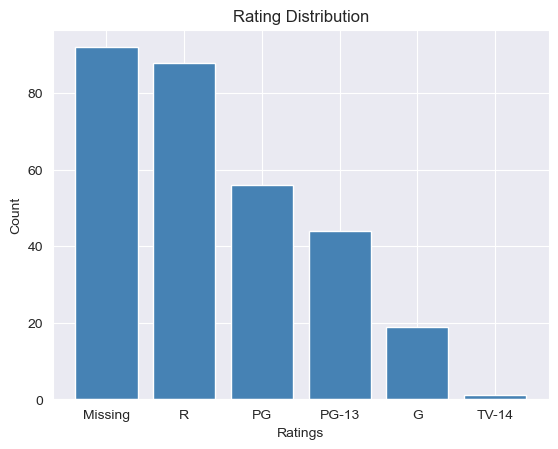

In [22]:
# Distribution of ratings
plt.bar(count_rating.index, count_rating, color='steelblue')

plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

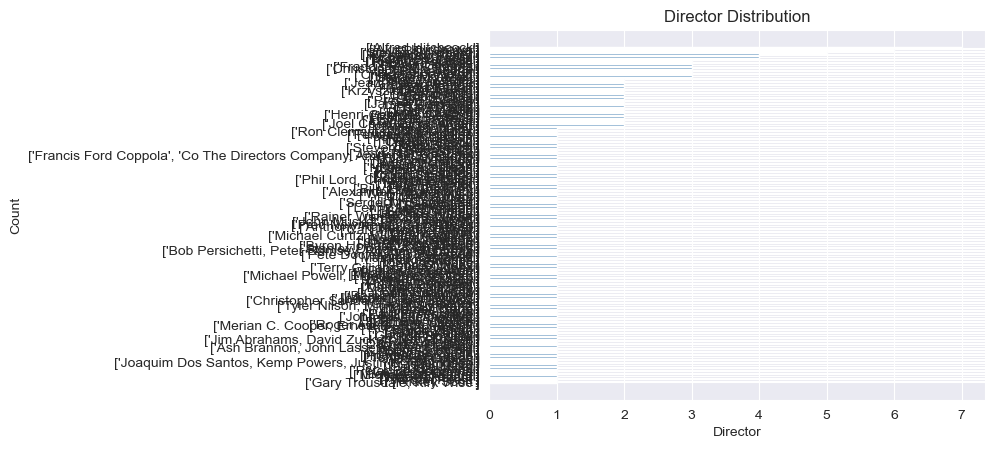

In [330]:
# Distribution of directors
plt.barh(count_director.index, count_director, color='steelblue')

plt.xlabel('Director')
plt.ylabel('Count')
plt.title('Director Distribution')
plt.show()

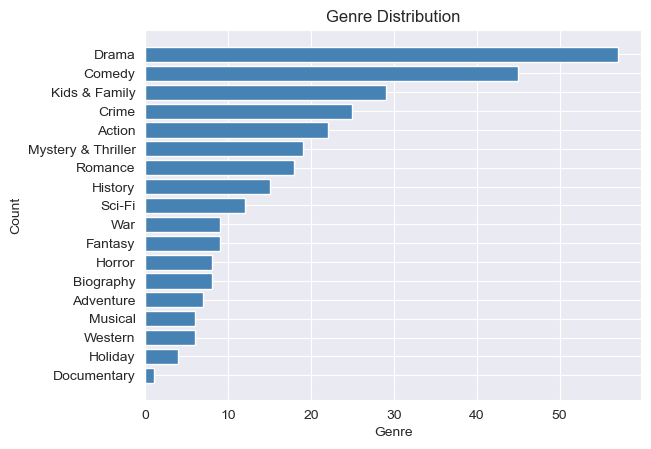

In [23]:
plt.barh(count_single_genre.index, count_single_genre, color='steelblue')

plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.show()

In [24]:
# Finding length of synopsis
# print(df['synopsis'][0])
# print(len(df['synopsis'][0])) # Characters. Expect 78 words based off wordcounter.net

count_words = []

for row in df['synopsis']:
    words = row.split()
    word_counts = len(words)
    print(word_counts)
    count_words.append(word_counts)

print(count_words)


78
81
49
54
20
79
131
77
79
77
76
84
51
72
81
50
77
52
76
76
75
74
87
61
76
78
61
64
52
83
79
79
73
77
84
75
80
57
76
79
51
75
71
71
57
92
73
81
68
84
63
87
75
51
73
79
68
84
66
44
100
75
84
69
31
64
70
23
72
69
78
82
20
76
78
53
69
75
81
62
52
88
79
74
77
75
76
61
46
77
44
76
84
79
32
78
75
79
61
78
54
78
93
82
83
67
74
76
70
71
49
29
25
90
75
49
85
58
67
79
76
80
75
52
80
76
78
93
76
44
79
77
35
80
82
74
75
53
83
77
78
65
74
92
53
72
69
217
64
31
83
74
57
47
84
139
72
77
61
32
71
82
67
63
77
89
46
90
41
57
78
30
78
77
83
78
73
40
82
73
73
78
78
74
70
87
23
58
78
78
72
18
83
81
84
73
88
82
58
74
80
58
85
34
82
85
66
78
78
71
77
54
149
74
79
53
77
77
83
75
75
71
16
82
89
75
76
65
77
73
50
82
79
79
84
70
82
80
81
70
70
79
73
73
67
80
73
17
47
83
48
83
82
76
53
53
65
80
82
81
76
80
69
69
56
79
82
69
88
83
87
46
75
55
82
73
92
83
85
65
78
77
76
74
73
70
75
69
78
72
70
78
59
85
67
90
77
37
70
75
[78, 81, 49, 54, 20, 79, 131, 77, 79, 77, 76, 84, 51, 72, 81, 50, 77, 52, 76, 76, 75, 74, 87, 6

In [25]:
df['synopsis_length'] = count_words
df.head()

,titles,urls,director,rating,genre,synopsis,single_genre,synopsis_length
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"[[Crime], [Drama]]","Three policemen, each with his own motives and...",Crime,78
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"[[Crime], [Drama]]",Widely regarded as one of the greatest films o...,Crime,81
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,[[Drama]],"Rick Blaine (Humphrey Bogart), who owns a nigh...",Drama,49
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],Missing,[[Action]],A samurai answers a village's request for prot...,Action,54
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"[[Comedy], [Mystery & Thriller], [Drama]]",Greed and class discrimination threaten the ne...,Comedy,20


Text(0.5, 1.0, 'Synopsis Length')

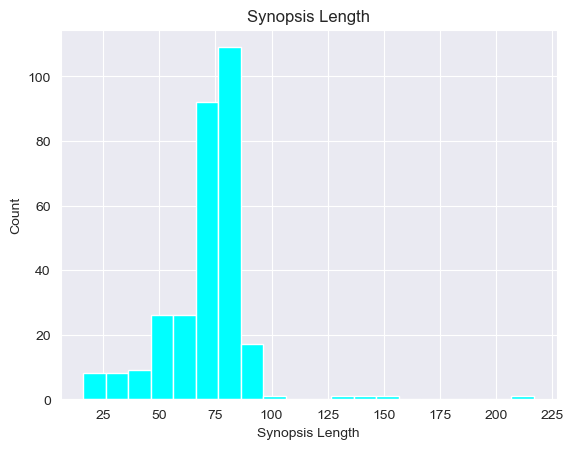

In [26]:
plt.hist(df['synopsis_length'], bins=20, color='aqua')

plt.xlabel('Synopsis Length')
plt.ylabel('Count')
plt.title('Synopsis Length')

In [27]:
avg_synopsis = np.mean(df['synopsis_length'])
print(f"The average synopsis is {avg_synopsis}")

med_synopsis = np.median(df['synopsis_length'])
print(f"The median synopsis is {med_synopsis}")  # length of synopsis is skewed so median more appropriate 

The average synopsis is 71.43333333333334
The median synopsis is 75.0


## Corpus Development

Create two different corpora to test the accuracy when using a customer stop words list compared to a predefined one.

Steps:
1. Normalisation
2. Tokenization 
3. Remove Punctuation 
4. Remove Stop words - Break into two different sets, custom and pre-defined
5. Parts of Speech (POS)
6. Legitimation



In [356]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\conno\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\conno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\conno\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conno\AppData\Roaming\nltk_data...


True

In [28]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if no specific tag found

In [148]:
# text = df['synopsis'][0]
def corpus_lemmatization(text):
    # Step 1: Lowercasing
    text = text.lower()

    # Step 2: Tokenization
    tokens = word_tokenize(text)

    # Step 3: Remove punctuation and special characters
    tokens = [word for word in tokens if word.isalpha()]

    # Step 4: Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Step 5: POS Tagging
    pos_tags = nltk.pos_tag(tokens)

    # Step 6: Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Function to get POS tag for lemmatization

    lemmatized_tokens = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])
    return lemmatized_tokens

# print(lemmatized_tokens)
# print(text)

In [30]:
def freq_words(x, terms=30):
    all_words = " ".join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), "count": list(fdist.values())})

    # selecting top 30 words
    d = words_df.nlargest(columns="count", n=terms)

    # Visualise words and frequencies
    plt.figure(figsize=(12, 15))
    ax = sns.barplot(data=d, x="count", y="word")
    ax.set(ylabel="word")
    plt.show()

In [149]:
df['clean_synopsis'] = df['synopsis'].apply(lambda x: corpus_lemmatization(x))


In [32]:
df.head()

,titles,urls,director,rating,genre,synopsis,single_genre,synopsis_length,clean_synopsis
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"[[Crime], [Drama]]","Three policemen, each with his own motives and...",Crime,78,three policeman motif obsession tackle corrupt...
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"[[Crime], [Drama]]",Widely regarded as one of the greatest films o...,Crime,81,widely regard one great film time mob drama ba...
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,[[Drama]],"Rick Blaine (Humphrey Bogart), who owns a nigh...",Drama,49,rick blaine humphrey bogart own nightclub casa...
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],Missing,[[Action]],A samurai answers a village's request for prot...,Action,54,samurai answer village request protection fall...
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"[[Comedy], [Mystery & Thriller], [Drama]]",Greed and class discrimination threaten the ne...,Comedy,20,greed class discrimination threaten newly form...


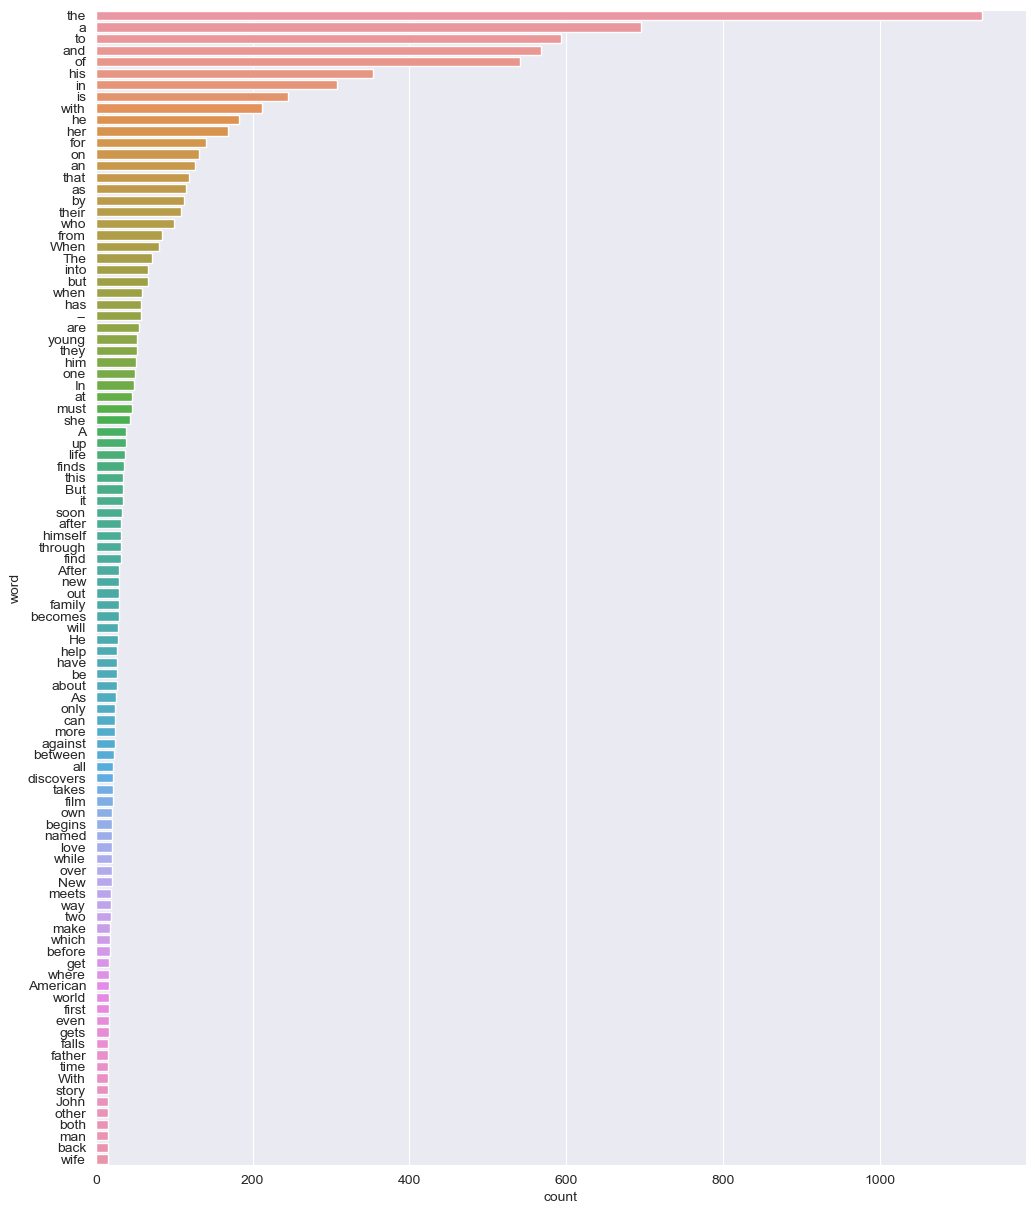

In [150]:
freq_words(df['synopsis'], 100)

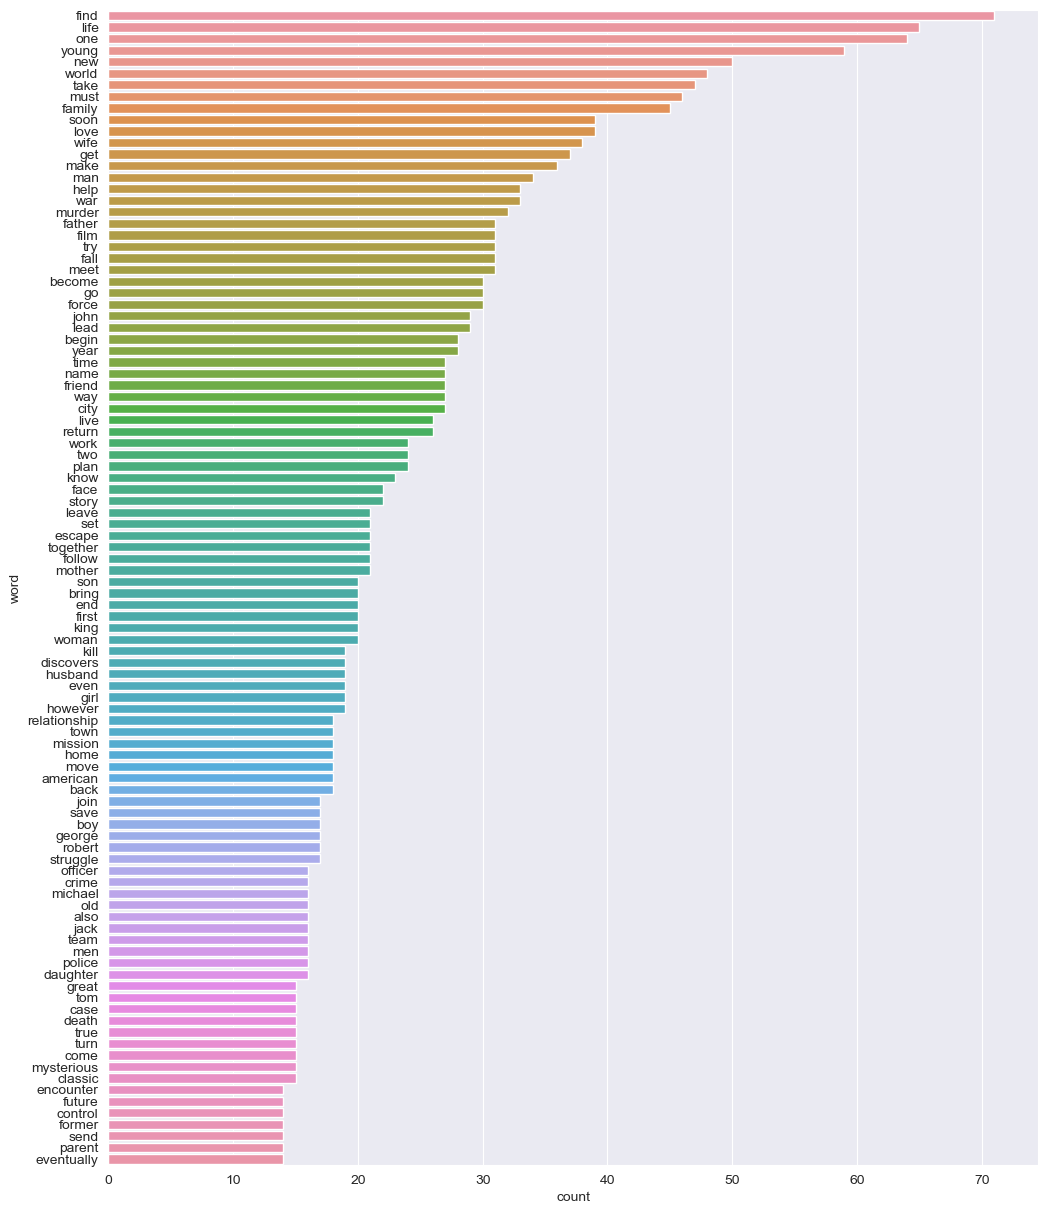

In [151]:
freq_words(df["clean_synopsis"], 100)


In [19]:
corpus_pre_defined = list(df["clean_synopsis"])

print(corpus_pre_defined)
print(len(corpus_pre_defined))


['three policeman motif obsession tackle corruption surround unsolved murder downtown los angeles coffee shop early detective lieutenant exley guy pearce son murder detective avenge father kill officer white russell crowe implicate scandal root exley one victim sergeant vincennes kevin spacey feed classify information tabloid magnate danny devito', 'widely regard one great film time mob drama base mario puzo novel name focus powerful crime family vito corleone marlon brando young son michael al pacino reluctantly join mafia becomes involve inevitable cycle violence betrayal although michael try maintain normal relationship wife kay diane keaton draw deep family business', 'rick blaine humphrey bogart own nightclub casablanca discovers old flame ilsa ingrid bergman town husband victor laszlo paul henreid laszlo famed rebel german tail ilsa know rick help get country', 'samurai answer village request protection fall hard time town need protection bandit samurai gather six others help tea

In [153]:
count_words = []

for row in df['clean_synopsis']:
    words = row.split()
    word_counts = len(words)
    print(word_counts)
    count_words.append(word_counts)

print(count_words)

47
49
30
30
14
46
74
47
51
49
49
56
24
41
42
32
43
32
49
50
41
46
51
32
46
44
32
43
31
42
47
48
52
48
51
43
44
32
47
47
31
44
39
41
27
55
49
47
39
45
40
52
50
31
52
52
35
47
35
23
52
48
47
47
18
34
39
13
43
42
48
52
16
47
45
29
43
42
52
35
26
46
50
47
51
51
42
40
24
50
26
52
44
44
18
45
43
46
33
49
34
45
48
55
44
42
48
49
44
37
28
17
15
44
47
26
50
38
38
52
47
41
49
28
43
48
47
45
49
25
50
48
16
50
53
50
49
28
53
46
49
39
46
48
33
40
41
133
40
17
50
48
33
32
50
78
44
45
31
17
46
53
43
36
36
43
24
52
25
30
40
20
43
54
55
50
49
24
51
44
49
44
47
46
44
46
13
34
53
47
42
9
49
43
44
47
43
49
34
46
40
35
46
22
46
57
35
43
41
43
51
30
93
47
47
35
47
52
46
46
47
49
8
46
47
47
53
38
48
46
29
50
38
51
49
34
48
53
47
47
45
46
49
47
44
45
46
14
27
47
27
50
45
48
27
22
38
45
52
44
42
49
46
35
25
53
44
51
45
53
23
45
28
50
40
51
54
49
36
50
48
48
52
51
52
46
49
42
46
42
48
29
52
49
40
51
22
40
47
[47, 49, 30, 30, 14, 46, 74, 47, 51, 49, 49, 56, 24, 41, 42, 32, 43, 32, 49, 50, 41, 46, 51, 32, 46, 44,

In [154]:
df['cleaned_synopsis_length'] = count_words

In [38]:
export_csv = df.to_csv('movies_df.csv', index=None, header=True)


In [9]:
df = pd.read_csv('movies_df.csv')

In [10]:
df.describe()

,synopsis_length,cleaned_synopsis_length
count,300.000000,300.000000
mean,71.433333,42.526667
std,18.816636,11.943399
min,16.000000,8.000000
25%,65.750000,38.000000
50%,75.000000,45.500000
75%,80.000000,49.000000
max,217.000000,133.000000


Text(0.5, 1.0, 'Cleaned Synopsis Length')

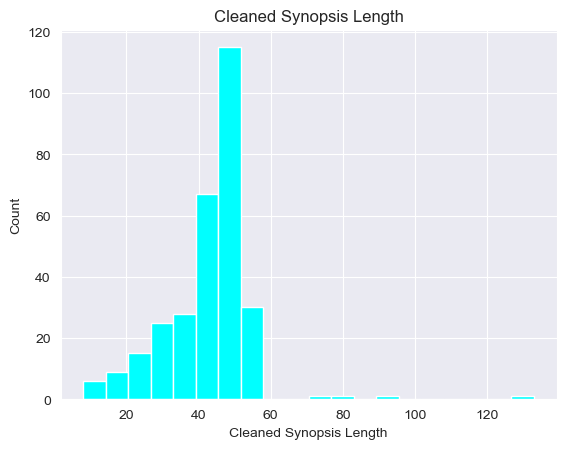

In [155]:
plt.hist(df['cleaned_synopsis_length'], bins=20, color='aqua')

plt.xlabel('Cleaned Synopsis Length')
plt.ylabel('Count')
plt.title('Cleaned Synopsis Length')

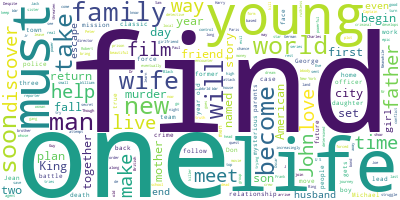

In [12]:
# Pre text cleaning
long_string_pre = ','.join(df['synopsis'].to_list())
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string_pre)
# Visualize the word cloud
wordcloud.to_image()

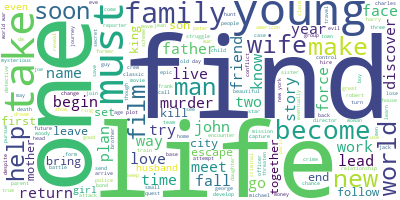

In [13]:
long_string_post = ','.join(df['clean_synopsis'].to_list())
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string_post)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
# Factorise Genres

#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = df['single_genre'].unique()
i = 0
idx2class = {}
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class

{0: 'Crime',
 1: 'Drama',
 2: 'Action',
 3: 'Comedy',
 4: 'History',
 5: 'Kids & Family',
 6: 'War',
 7: 'Mystery & Thriller',
 8: 'Fantasy',
 9: 'Romance',
 10: 'Musical',
 11: 'Holiday',
 12: 'Horror',
 13: 'Sci-Fi',
 14: 'Adventure',
 15: 'Western',
 16: 'Biography',
 17: 'Documentary'}

In [12]:
df['label'] = df['single_genre'].replace(class2idx)
df.head()


C:\Users\conno\AppData\Local\Temp\ipykernel_11516\2168831310.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['single_genre'].replace(class2idx)


,titles,urls,director,rating,genre,synopsis,single_genre,synopsis_length,clean_synopsis,cleaned_synopsis_length,label
0,L.A. Confidential,https://www.rottentomatoes.com/m/la_confidential,['Curtis Hanson'],R,"[['Crime'], ['Drama']]","Three policemen, each with his own motives and...",Crime,78,three policeman motif obsession tackle corrupt...,47,0
1,The Godfather,https://www.rottentomatoes.com/m/the_godfather,['Francis Ford Coppola'],R,"[['Crime'], ['Drama']]",Widely regarded as one of the greatest films o...,Crime,81,widely regard one great film time mob drama ba...,49,0
2,Casablanca,https://www.rottentomatoes.com/m/1003707-casab...,['Michael Curtiz'],PG,[['Drama']],"Rick Blaine (Humphrey Bogart), who owns a nigh...",Drama,49,rick blaine humphrey bogart own nightclub casa...,30,1
3,Seven Samurai,https://www.rottentomatoes.com/m/seven_samurai...,['Akira Kurosawa'],Missing,[['Action']],A samurai answers a village's request for prot...,Action,54,samurai answer village request protection fall...,30,2
4,Parasite,https://www.rottentomatoes.com/m/parasite_2019,['Bong Joon Ho'],R,"[['Comedy'], ['Mystery & Thriller'], ['Drama']]",Greed and class discrimination threaten the ne...,Comedy,20,greed class discrimination threaten newly form...,14,3


In [13]:
df = df[df.single_genre != 'Documentary']
corpus_pre_defined = list(df["clean_synopsis"])  # Corpus

In [17]:
avg_single_genre = np.mean(count_single_genre.values)
print(round(avg_single_genre))

NameError: name 'count_single_genre' is not defined

In [ ]:
# CountVecotrizer

# count_vectorizer = CountVectorizer(max_df=0.85, min_df=0.01,max_features=1500,stop_words='english')

In [19]:
# Turn the words into vectors

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=0.01, max_features=1500)

X = tfidf_vectorizer.fit_transform(corpus_pre_defined).toarray()
y = df.iloc[:, -1].values

In [15]:
print(X)
print(X.shape)
print(y.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.09998891]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.14136452]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(299, 1044)
(299,)


In [20]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)
print(len(features))

['ability' 'able' 'aboard' ... 'yet' 'york' 'young']
1044


In [21]:
# Training / test set
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110, stratify=y)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))



X_train shape: (239, 1044)
X_test shape: (60, 1044)
y_train shape: (239,)
y_test shape: (60,)


In [22]:
# Apply SMOTE to only the X_train set
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=2, random_state=42,
              sampling_strategy='auto')  # Finds majority class, then synthetically matches the same sample number
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(f"Original dataset shape {y_train.shape} | New data shape {y_smote.shape}")
print(f"{abs(y_train.shape[0] - y_smote.shape[0])}")  # 
# y_smote

Original dataset shape (239,) | New data shape (782,)
543


In [23]:
# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=8)  # 0.25 x 0.8 = 0.2

print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_val shape: (179,)
y val shape: (60,)


### Data Normalisation Technique

SMOTE applied after train/test split



In [46]:
# df['single_genre'].value_counts()

single_genre
Drama                 57
Comedy                45
Kids & Family         29
Crime                 25
Action                22
Mystery & Thriller    19
Romance               18
History               15
Sci-Fi                12
Fantasy                9
War                    9
Horror                 8
Biography              8
Adventure              7
Musical                6
Western                6
Holiday                4
Name: count, dtype: int64

In [24]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X, y)  # Randomly undersamples the data

print(f"Original dataset shape {y.shape} | New data shape {y_nm.shape}")  # 
print(f"A lose {abs(y.shape[0] - y_nm.shape[0])} samples")

Original dataset shape (299,) | New data shape (68,)
A lose 231 samples


# Task 4: Machine Learning

### XGBoost Machine Learning

In [25]:
#allow logloss and classification error plots for each iteration of xgb model
import xgboost as xgb


def plot_compare(metrics, eval_results, epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6, 6]
        plt.plot(rang, test_score, "c", label="Val")
        plt.plot(rang, train_score, "orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()


def fitXgb(sk_model, training_data, epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0], ))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss', 'merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'), (train, 'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=store, verbose_eval=5)
    print('-- Model Report --')
    print(
        'XGBoost Accuracy: ' + str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): ' + str(
        f1_score(sk_model.predict(training_data['X_test']), training_data['Y_test'], average='micro')))
    plot_compare(metrics, store, epochs)

In [26]:
from xgboost.sklearn import XGBClassifier

#initial model
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=9,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='multi:softprob',
                     nthread=4,
                     num_class=17,
                     seed=2789,
                     eval_metric='merror')

### XGBoost initial testing

Fitting model...
Fitting done!
[0]	val-mlogloss:2.62363	val-merror:0.43333	train-mlogloss:2.43447	train-merror:0.17903


C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[5]	val-mlogloss:1.99167	val-merror:0.18333	train-mlogloss:1.45454	train-merror:0.05115
[10]	val-mlogloss:1.54537	val-merror:0.10000	train-mlogloss:0.97904	train-merror:0.02558
[15]	val-mlogloss:1.21415	val-merror:0.03333	train-mlogloss:0.68909	train-merror:0.01279
[20]	val-mlogloss:0.96053	val-merror:0.00000	train-mlogloss:0.50114	train-merror:0.00767
[25]	val-mlogloss:0.77245	val-merror:0.01667	train-mlogloss:0.37385	train-merror:0.00384
[30]	val-mlogloss:0.61979	val-merror:0.00000	train-mlogloss:0.28412	train-merror:0.00256
[35]	val-mlogloss:0.51077	val-merror:0.00000	train-mlogloss:0.22154	train-merror:0.00128
[40]	val-mlogloss:0.42468	val-merror:0.00000	train-mlogloss:0.17696	train-merror:0.00000
[45]	val-mlogloss:0.35640	val-merror:0.00000	train-mlogloss:0.14365	train-merror:0.00000
[49]	val-mlogloss:0.31116	val-merror:0.00000	train-mlogloss:0.12262	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.23333333333333334
XGBoost F1-Score (Micro): 0.23333333333333334


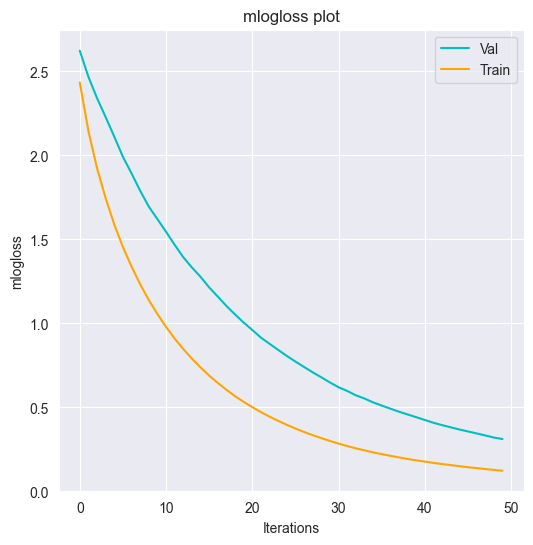

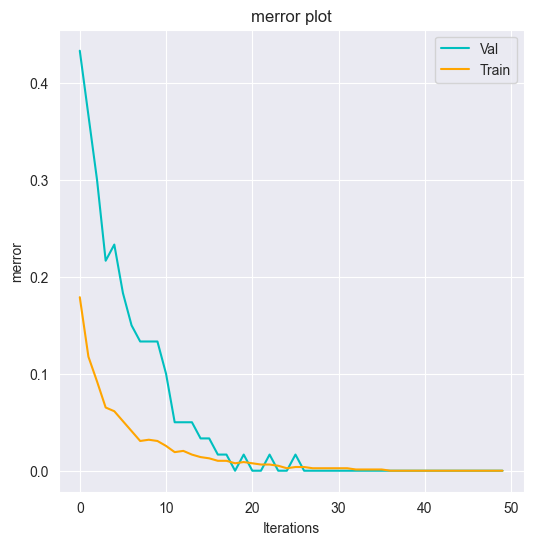

In [27]:
# SMOTE training/val/test 
training_data_smote = {'X_train': X_smote, 'Y_train': y_smote,
                       'X_val': X_val, 'Y_val': y_val,
                       'X_test': X_test, 'Y_test': y_test}
fitXgb(xgb1, training_data_smote, 50)

In [28]:
preds = xgb1.predict(X_test)
labels = y_test

In [30]:
print(confusion_matrix(labels, preds))
print(accuracy_score(labels, preds))
print(recall_score(labels, preds, average=None))
print(precision_score(labels, preds, average=None))

[[2 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2 1 1 0 0 0 0 0 1 1 0 0 2 0 0 0]
 [1 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 2 0 2 0 1 0 1 0 0 0 0 0 0 0]
 [0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 3 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
0.23333333333333334
[0.4        0.18181818 0.5        0.22222222 0.         0.5
 0.         0.25       0.         0.25       1.         0.
 0.         0.         0.         0.         0.        ]
[0.28571429 0.15384615 0.33333333 0.15384615 0.         0.5
 0.         0.33333333 0.         0.33333333 0.5        0.
 0.         0.         0.         0.         0.        

C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Hyperparameter tuning SMOTE

In [79]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x, y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param": gs.best_params_}
    return results, best

In [32]:
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator=xgb1, param_grid=param_test1, scoring='f1_macro', n_jobs=-1, verbose=10, cv=5)
gsearch1.fit(X_smote, y_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='merror', feature_types=None,
                                     gamma=0, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4, num_class=17, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1_macro', verbose=10)

In [33]:
getTrainScores(gsearch1)

({0: "mean:0.8325274945617324params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.797494275535319params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.7749968535305412params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.8362719433764543params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.8113007810398735params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.7804883307996703params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.8361470806209231params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.8054069919775262params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.7786367137103916params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.8347840027424802params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.8080975456302474params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.7798265394859032params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.8362719433764543,
  'best_param': {'max_depth': 5, 'min_c

Fitting model...
Fitting done!
[0]	val-mlogloss:2.79376	val-merror:0.83333	train-mlogloss:2.72617	train-merror:0.68156
[5]	val-mlogloss:2.73559	val-merror:0.90000	train-mlogloss:2.29190	train-merror:0.46927
[10]	val-mlogloss:2.72107	val-merror:0.90000	train-mlogloss:1.94488	train-merror:0.32961
[15]	val-mlogloss:2.69922	val-merror:0.90000	train-mlogloss:1.64708	train-merror:0.21788


C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	val-mlogloss:2.71339	val-merror:0.86667	train-mlogloss:1.38716	train-merror:0.14525
[25]	val-mlogloss:2.72758	val-merror:0.86667	train-mlogloss:1.16644	train-merror:0.10615
[30]	val-mlogloss:2.75170	val-merror:0.85000	train-mlogloss:0.98787	train-merror:0.06704
[35]	val-mlogloss:2.75835	val-merror:0.85000	train-mlogloss:0.83930	train-merror:0.05028
[40]	val-mlogloss:2.77065	val-merror:0.85000	train-mlogloss:0.71592	train-merror:0.02793
[45]	val-mlogloss:2.79275	val-merror:0.85000	train-mlogloss:0.61536	train-merror:0.02235
[49]	val-mlogloss:2.81278	val-merror:0.85000	train-mlogloss:0.54886	train-merror:0.02235
-- Model Report --
XGBoost Accuracy: 0.21666666666666667
XGBoost F1-Score (Micro): 0.21666666666666667


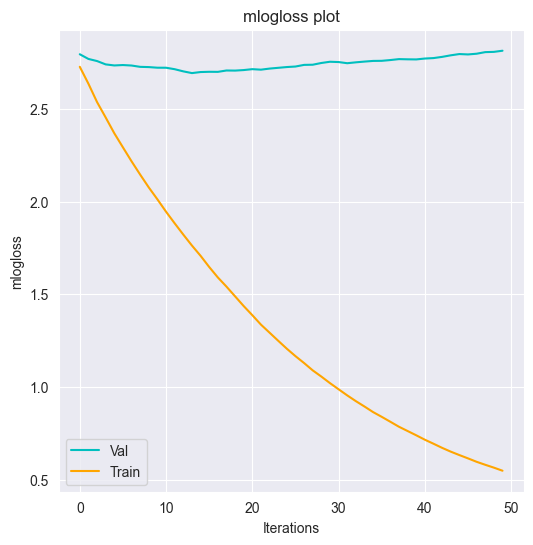

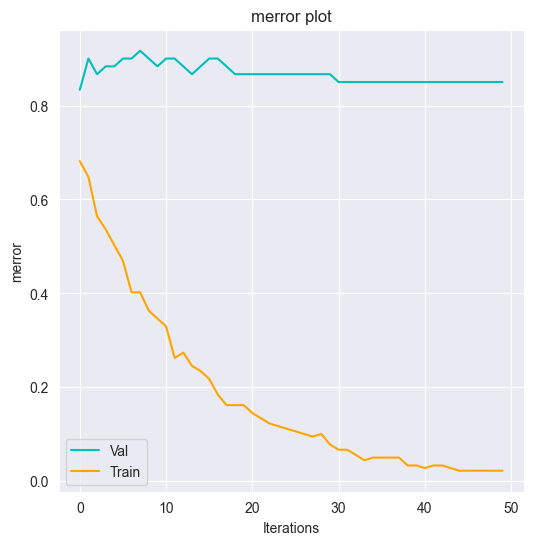

In [34]:
# standard training/val/test 
training_data = {'X_train': X_train, 'Y_train': y_train,
                 'X_val': X_val, 'Y_val': y_val,
                 'X_test': X_test, 'Y_test': y_test}
fitXgb(xgb1, training_data, 50)

### Standard test/training set

In [36]:

param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch_standard_split = GridSearchCV(estimator=xgb1, param_grid=param_test1, scoring='f1_micro', n_jobs=-1, verbose=10,
                                      cv=2)
gsearch_standard_split.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='merror', feature_types=None,
                                     gamma=0, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4, num_class=17, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1_micro', verbose=10)

In [38]:
getTrainScores(gsearch_standard_split)


({0: "mean:0.11716604244694132params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.10617977528089888params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.16735330836454432params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.1114856429463171params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.10617977528089888params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.16735330836454432params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.12272159800249688params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.10617977528089888params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.16735330836454432params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.12265917602996254params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.10617977528089888params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.16735330836454432params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.16735330836454432,
  'best_param': {'max_dept

Fitting model...
Fitting done!
[0]	val-mlogloss:2.82173	val-merror:0.81667	train-mlogloss:2.80705	train-merror:0.80882
[5]	val-mlogloss:2.77854	val-merror:0.86667	train-mlogloss:2.64906	train-merror:0.69118
[10]	val-mlogloss:2.73812	val-merror:0.86667	train-mlogloss:2.51382	train-merror:0.64706
[15]	val-mlogloss:2.70216	val-merror:0.78333	train-mlogloss:2.35181	train-merror:0.58824
[20]	val-mlogloss:2.66562	val-merror:0.75000	train-mlogloss:2.19722	train-merror:0.51471
[25]	val-mlogloss:2.61503	val-merror:0.76667	train-mlogloss:2.02949	train-merror:0.50000
[30]	val-mlogloss:2.55568	val-merror:0.75000	train-mlogloss:1.88739	train-merror:0.47059
[35]	val-mlogloss:2.50575	val-merror:0.71667	train-mlogloss:1.73095	train-merror:0.39706
[40]	val-mlogloss:2.45607	val-merror:0.70000	train-mlogloss:1.59153	train-merror:0.35294
[45]	val-mlogloss:2.41113	val-merror:0.65000	train-mlogloss:1.46905	train-merror:0.27941


C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[49]	val-mlogloss:2.37261	val-merror:0.63333	train-mlogloss:1.36374	train-merror:0.23529
-- Model Report --
XGBoost Accuracy: 0.15
XGBoost F1-Score (Micro): 0.15


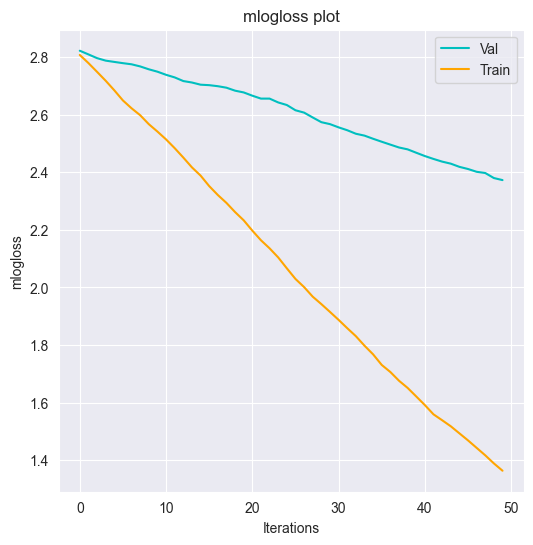

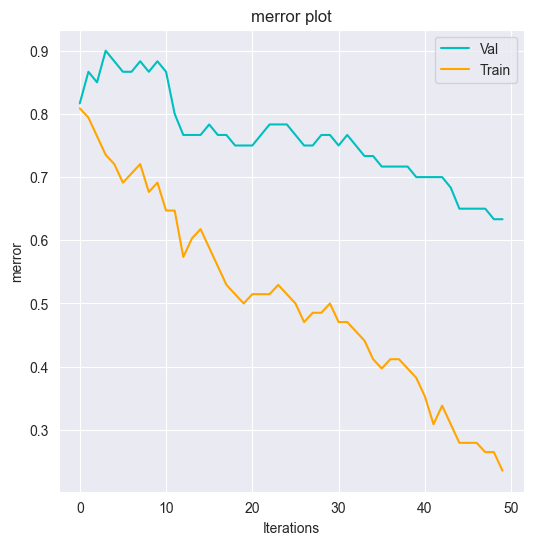

In [39]:
# NearMiss training/val/test
training_data = {'X_train': x_nm, 'Y_train': y_nm,
                 'X_val': X_val, 'Y_val': y_val,
                 'X_test': X_test, 'Y_test': y_test}
fitXgb(xgb1, training_data, 50)

### NearMiss Hyperparameter

In [42]:
# Near Miss 
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch_standard_nm = GridSearchCV(estimator=xgb1, param_grid=param_test1, scoring='f1_micro', n_jobs=-1, verbose=10,
                                   cv=2)
gsearch_standard_nm.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='merror', feature_types=None,
                                     gamma=0, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4, num_class=17, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1_micro', verbose=10)

In [43]:
getTrainScores(gsearch_standard_nm)

({0: "mean:0.11716604244694132params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.10617977528089888params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.16735330836454432params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.1114856429463171params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.10617977528089888params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.16735330836454432params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.12272159800249688params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.10617977528089888params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.16735330836454432params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.12265917602996254params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.10617977528089888params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.16735330836454432params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.16735330836454432,
  'best_param': {'max_dept

## Support Vector Machine

In [110]:
# Support Vector Machine

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_svm_standard = sc.fit_transform(X_train)
x_train_svm_smote = sc.fit_transform(X_smote)
x_test_svm = sc.transform(X_test)

y_train_svm = y_smote

In [118]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf', gamma='auto', random_state=2789)
svm_poly = SVC(kernel='poly', degree=2, gamma='auto', random_state=2789)

svm_sigmoid = SVC(kernel='sigmoid', random_state=2789)

svm_linear = SVC(kernel='linear', random_state=2789)

svm_rbf.fit(x_train_svm_smote, y_train_svm)

svm_poly.fit(x_train_svm_smote, y_train_svm)

svm_sigmoid.fit(x_train_svm_smote, y_train_svm)

svm_linear.fit(x_train_svm_smote, y_train_svm)

SVC(kernel='linear', random_state=2789)

In [119]:
y_pred_rbf = svm_rbf.predict(x_test_svm)

y_pred_poly = svm_poly.predict(x_test_svm)

y_pred_sigmoid = svm_sigmoid.predict(x_test_svm)

y_pred_linear = svm_linear.predict(x_test_svm)


In [77]:
def calculate_f1_score_macro(y_test_val, y_pred):
    return f1_score(y_test_val, y_pred, average='macro')


def calculate_f1_score_micro(y_test_val, y_pred):
    return f1_score(y_test_val, y_pred, average='micro')

In [120]:

print(f'Macro F1 Score (rbf): {calculate_f1_score_macro(y_test, y_pred_rbf)}')
print(f'Micro F1 Score (rbf): {calculate_f1_score_micro(y_test, y_pred_rbf)}')

print(f"Macro F1 Score (poly): {calculate_f1_score_macro(y_test, y_pred_poly)}")
print(f"Micro F1 Score (poly): {calculate_f1_score_micro(y_test, y_pred_poly)}")

print(f"Macro F1 Score (sigmoid): {calculate_f1_score_macro(y_test, y_pred_sigmoid)}")
print(f"Micro F1 Score (sigmoid): {calculate_f1_score_micro(y_test, y_pred_sigmoid)}")

print(f"Macro F1 Score (linear): {calculate_f1_score_macro(y_test, y_pred_linear)}")
print(f"Micro F1 Score (linear): {calculate_f1_score_micro(y_test, y_pred_linear)}")


Macro F1 Score (rbf): 0.018227009113504555
Micro F1 Score (rbf): 0.18333333333333332
Macro F1 Score (poly): 0.2275645393292452
Micro F1 Score (poly): 0.25
Macro F1 Score (sigmoid): 0.17104072398190048
Micro F1 Score (sigmoid): 0.31666666666666665
Macro F1 Score (linear): 0.18956043956043955
Micro F1 Score (linear): 0.35


### Hyper Parameter Tuning

In [80]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf', 'sigmoid', 'linear']}

grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=3, cv=5, n_jobs=-1)

# fitting the model for grid search 
grid_svm.fit(x_train_svm_smote, y_train_svm)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=3)

In [81]:
# gsearch1 = GridSearchCV(estimator=xgb1, param_grid=param_test1, scoring='f1_macro', n_jobs=-1, verbose=10, cv=5)
# gsearch1.fit(X_smote, y_smote)
getTrainScores(grid_svm)

({0: "mean:0.16628286787522456params{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",
  1: "mean:0.20337252980565085params{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",
  2: "mean:0.9488894332843378params{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",
  3: "mean:0.2558141433937612params{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",
  4: "mean:0.26987587783766126params{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}",
  5: "mean:0.9488894332843378params{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}",
  6: "mean:0.397844194022538params{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",
  7: "mean:0.6932386085252327params{'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}",
  8: "mean:0.9488894332843378params{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}",
  9: "mean:0.692062714355708params{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",
  10: "mean:0.6805079209537809params{'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}",
  11: "mean:0.9488894332843378params{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}",
  12: "mean:0.7061

### Validation of Hyper tuning

In [123]:
# Best parameters {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

svm_linear_tuned = SVC(kernel='linear', C=0.1, gamma=1, random_state=2789)

svm_linear_tuned.fit(x_train_svm_standard, y_train)
y_pred_linear_refined = svm_linear_tuned.predict(x_test_svm)

In [124]:
# SMOTE training set
svm_linear_tuned.fit(X_smote, y_smote)
y_pred_linear_refined_2 = svm_linear.predict(x_test_svm)

In [128]:
# Near Miss Training set
svm_linear_tuned.fit(x_nm, y_nm)
y_pred_linear_refined_3 = svm_linear.predict(x_test_svm)

In [129]:
print(f"Macro F1 Score (linear): {calculate_f1_score_macro(y_test, y_pred_linear_refined)}")
print(f"Micro F1 Score (linear): {calculate_f1_score_micro(y_test, y_pred_linear_refined)}")
print(f"Macro F1 Score (linear, using SMOTE): {calculate_f1_score_macro(y_test, y_pred_linear_refined_2)}")
print(f"Micro F1 Score (linear, using SMOTE): {calculate_f1_score_micro(y_test, y_pred_linear_refined_2)}")
print(f"Macro F1 Score (linear, using NM): {calculate_f1_score_macro(y_test, y_pred_linear_refined_3)}")
print(f"Micro F1 Score (linear, using NM): {calculate_f1_score_micro(y_test, y_pred_linear_refined_3)}")

Macro F1 Score (linear): 0.15802689870274353
Micro F1 Score (linear): 0.2833333333333333
Macro F1 Score (linear, using SMOTE): 0.18956043956043955
Micro F1 Score (linear, using SMOTE): 0.35
Macro F1 Score (linear, using NM): 0.18956043956043955
Micro F1 Score (linear, using NM): 0.35


## Multinomial Naives Bayes


In [132]:
# 
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(corpus_pre_defined, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train_count)
X_test_counts = vectorizer.transform(X_test_count)


In [143]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train_count)

MultinomialNB()

In [146]:
from sklearn.metrics import classification_report

y_pred_multi_no = clf.predict(X_test_counts)
print(classification_report(y_test_count, y_pred_multi_no))
print(f"Macro F1 Score (MultiNo): {calculate_f1_score_macro(y_test_count, y_pred_multi_no)}")
print(f"Micro F1 Score (MultiNo): {calculate_f1_score_micro(y_test_count, y_pred_multi_no)}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.19      0.50      0.27        12
           2       1.00      0.40      0.57         5
           3       0.13      0.40      0.20         5
           4       0.00      0.00      0.00         3
           5       0.67      0.44      0.53         9
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1

    accuracy                           0.23        60
   macro avg       0.13      0.12      0.11        60
weighted avg       0.23   

C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [139]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [1, 2],
    'vectorizer__stop_words': [None, 'english'],
    'classifier__alpha': [0.5, 1.0, 1.5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Make predictions on the test data with the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the best model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 72 candidates, totalling 144 fits


ValueError: 
All the 144 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1389, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1276, in _count_vocab
    for feature in analyze(doc):
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 110, in _analyze
    doc = preprocessor(doc)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 68, in _preprocess
    doc = doc.lower()
AttributeError: 'numpy.ndarray' object has no attribute 'lower'


## Random Forest

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 535, in fit_transform
    Xt = self._fit(X, y, routed_params)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1389, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1276, in _count_vocab
    for feature in analyze(doc):
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 110, in _analyze
    doc = preprocessor(doc)
  File "C:\Users\conno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 68, in _preprocess
    doc = doc.lower()
AttributeError: 'numpy.ndarray' object has no attribute 'lower'


## Text Cleaning Functions:

Justification of why sample was chosen

How does my topic relate to the real world. What are the real world applications? Proof of concept? 
Word2Vec TF-IDF
Functions for code

Word embedding
Ethics of webscrapper. Why chosen?

Beatiful soup why?

Improved Netflix recommendations from the model. 

In [377]:
# Text cleaning functions

def remove_by_regex(texts, regexp):
    """Removes text by regexp from a list."""
    output_texts = regexp.sub("", texts)
    return output_texts


def text_preprocessing(uncleaned_text):
    """Preprocessing text by removing urls and punctuation."""
    review = re.sub('[^a-zA-Z]', ' ', uncleaned_text)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    return review